<a href="https://colab.research.google.com/github/hemantnyadav/Multiple-Time-Series-Forecasting/blob/main/Multiple_Time_Series_forecsting_using_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multiple Time Series Forecasting

This experiment is to test forecasting of multiple timeseries from same domain. RandomForestRegressor from SkLearn is used to forecast sales of total 811 products(it means 811 time series). 

The point here is to check geeralization ability of forecasting method on different time series of same domain. So one model will be trained to  forecast any product.

Also, here single step(next timestamp) and multi-step(Next to next timestamp are forecasted and compared with baseline.



In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

## Load Data...

Dataset used here is Sales_Transactions_Dataset_Weekly from https://archive.ics.uci.edu/ . It is having weekly sales record of 811 products for 52 weeks.

In [3]:
data  = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv")
data = data.filter(regex=r'Product|W')


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


In [6]:
data.shape

(811, 53)

In [7]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
melt.tail()

,Product_Code,Week,Sales
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0
42171,P819,W51,1


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


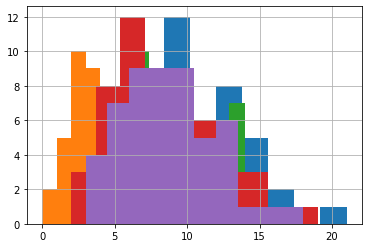

In [18]:
for i in range(5):
  print(data.iloc[i,1:].hist())

In [19]:
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [20]:
split_point = 40
melt_train = melt[melt['Week'] < split_point].copy()
melt_valid = melt[melt['Week'] >= split_point].copy()

In [21]:
melt_train['sales_next_week'] = melt_train.groupby("Product_Code")['Sales'].shift(-1)
melt_train[melt_train['Product_Code'] == 1].head()

,Product_Code,Week,Sales,sales_next_week
0,1,0,11,12.0
811,1,1,12,10.0
1622,1,2,10,8.0
2433,1,3,8,13.0
3244,1,4,13,12.0


In [22]:
melt_train.tail()

,Product_Code,Week,Sales,sales_next_week
32435,815,39,2,NaN
32436,816,39,6,NaN
32437,817,39,0,NaN
32438,818,39,0,NaN
32439,819,39,0,NaN


In [24]:
melt_valid['sales_next_week'] = melt_valid.groupby("Product_Code")['Sales'].shift(-1)
melt_train.tail()

,Product_Code,Week,Sales,sales_next_week
32435,815,39,2,NaN
32436,816,39,6,NaN
32437,817,39,0,NaN
32438,818,39,0,NaN
32439,819,39,0,NaN


In [25]:
melt_train = melt_train.dropna()
melt_train.tail()

,Product_Code,Week,Sales,sales_next_week
31624,815,38,1,2.0
31625,816,38,4,6.0
31626,817,38,0,0.0
31627,818,38,0,0.0
31628,819,38,1,0.0


## Create 4 Fundamental Features
1. Lag
2. Difference
3. Rolling Statistics
4. Date Components

### 1. Lag Features

In [28]:
melt_train["lag_sales_1"] = melt_train.groupby("Product_Code")['Sales'].shift(1)
melt_valid["lag_sales_1"] = melt_valid.groupby("Product_Code")['Sales'].shift(1)
melt_train[melt_train['Product_Code'] == 1].head()

,Product_Code,Week,Sales,sales_next_week,lag_sales_1,diff_sales_1
0,1,0,11,12.0,NaN,NaN
811,1,1,12,10.0,11.0,1.0
1622,1,2,10,8.0,12.0,-2.0
2433,1,3,8,13.0,10.0,-2.0
3244,1,4,13,12.0,8.0,5.0


### 2. Diffenrence

In [29]:
melt_train["diff_sales_1"] = melt_train.groupby("Product_Code")['Sales'].diff(1)
melt_valid["diff_sales_1"] = melt_valid.groupby("Product_Code")['Sales'].diff(1)
melt_train[melt_train['Product_Code'] == 1].head()

,Product_Code,Week,Sales,sales_next_week,lag_sales_1,diff_sales_1
0,1,0,11,12.0,NaN,NaN
811,1,1,12,10.0,11.0,1.0
1622,1,2,10,8.0,12.0,-2.0
2433,1,3,8,13.0,10.0,-2.0
3244,1,4,13,12.0,8.0,5.0


### 3. Rolling statistics
- Mean, Max, Min, STD

In [30]:
melt_train.groupby("Product_Code")['Sales'].rolling(4).mean()
melt_train.groupby("Product_Code")['Sales'].rolling(4).mean().reset_index(level=0, drop=True)
melt_train["mean_sales_4"] = melt_train.groupby("Product_Code")['Sales'].rolling(4).mean().reset_index(level=0, drop=True)
melt_valid["mean_sales_4"] = melt_valid.groupby("Product_Code")['Sales'].rolling(4).mean().reset_index(level=0, drop=True)
melt_train[melt_train['Product_Code'] == 1].head()


,Product_Code,Week,Sales,sales_next_week,lag_sales_1,diff_sales_1,mean_sales_4
0,1,0,11,12.0,NaN,NaN,NaN
811,1,1,12,10.0,11.0,1.0,NaN
1622,1,2,10,8.0,12.0,-2.0,NaN
2433,1,3,8,13.0,10.0,-2.0,10.25
3244,1,4,13,12.0,8.0,5.0,10.75


### 4. Date components (seasonality) - not available in this dataset
- Day of week, Day of year, Month, Day of month

## Evaluation metric
1. MAPE
2. WMAPE

In [31]:
def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    #ape[~np.isfinite(ape)] = 0. # VERY questionable
    ape[~np.isfinite(ape)] = 1. # pessimist estimate
    return np.mean(ape)

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

## Baseline
- Predict next week sales as equal to this week sales

In [32]:
y_pred = melt_train['Sales']
y_true = melt_train['sales_next_week']
print("MAPE", mape(y_true, y_pred))
print("WMAPE", wmape(y_true, y_pred))

MAPE 0.6721872645511404
WMAPE 0.30816465612331645


## Training RandomForestRegressor


In [34]:
features = ['Sales', 'lag_sales_1', 'diff_sales_1', 'mean_sales_4']
imputer = SimpleImputer()
Xtr = imputer.fit_transform(melt_train[features])
ytr = melt_train['sales_next_week']

In [35]:
mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

## Evaluate RandomForestRegressor and compare with baseline

In [36]:
Xval = imputer.transform(melt_valid[features])
yval = melt_valid['sales_next_week']

p = mdl.predict(Xval)

print("MAPE", mape(yval, p))
print("WMAPE", wmape(yval, p))

MAPE 0.6463137461455405
WMAPE 0.3004969729507602


## MultiStep Forecasting using Same Model

In [37]:
melt_train['sales_next_next_week'] = melt_train.groupby("Product_Code")['Sales'].shift(-2)
melt_valid['sales_next_next_week'] = melt_valid.groupby("Product_Code")['Sales'].shift(-2)

In [40]:
melt_train = melt_train.dropna(subset=['sales_next_week','sales_next_next_week'])
melt_train.head()

,Product_Code,Week,Sales,sales_next_week,lag_sales_1,diff_sales_1,mean_sales_4,sales_next_next_week
0,1,0,11,12.0,NaN,NaN,NaN,10.0
1,2,0,7,6.0,NaN,NaN,NaN,3.0
2,3,0,7,11.0,NaN,NaN,NaN,8.0
3,4,0,12,8.0,NaN,NaN,NaN,13.0
4,5,0,8,5.0,NaN,NaN,NaN,13.0


In [41]:
imputer = SimpleImputer()
Xtr = imputer.fit_transform(melt_train[features])
ytr = melt_train[['sales_next_week', 'sales_next_next_week']]

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

In [42]:
Xval = imputer.transform(melt_valid[features])
yval = melt_valid[['sales_next_week', 'sales_next_next_week']]

p = mdl.predict(Xval)

In [43]:
mape(yval, p)

sales_next_week         0.647034
sales_next_next_week    0.681146
dtype: float64

In [44]:
wmape(yval, p)

sales_next_week         0.300301
sales_next_next_week    0.310315
dtype: float64